YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


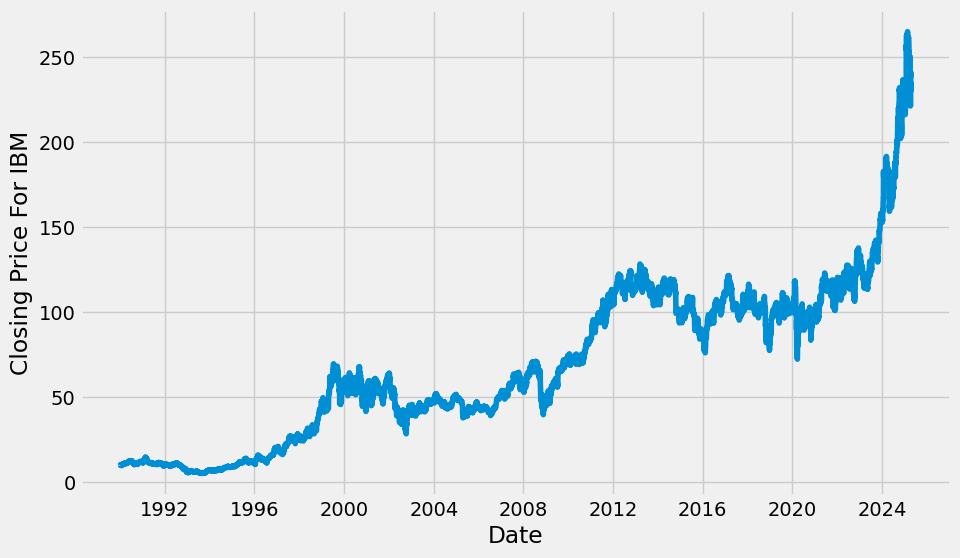

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

plt.style.use('fivethirtyeight')


"""Using IBM"""

IBM = yf.download(tickers="IBM",start="1990-01-01",end="2025-04-20")['Close']
IBM = IBM.reset_index()

df = IBM.reset_index()
df = IBM[['Date','IBM']]

df['IBM']
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')

df.isnull().sum()
df.duplicated().sum()
df.drop_duplicates(inplace=True)


plt.figure(figsize=(10,6))
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Closing Price For IBM')
plt.show()

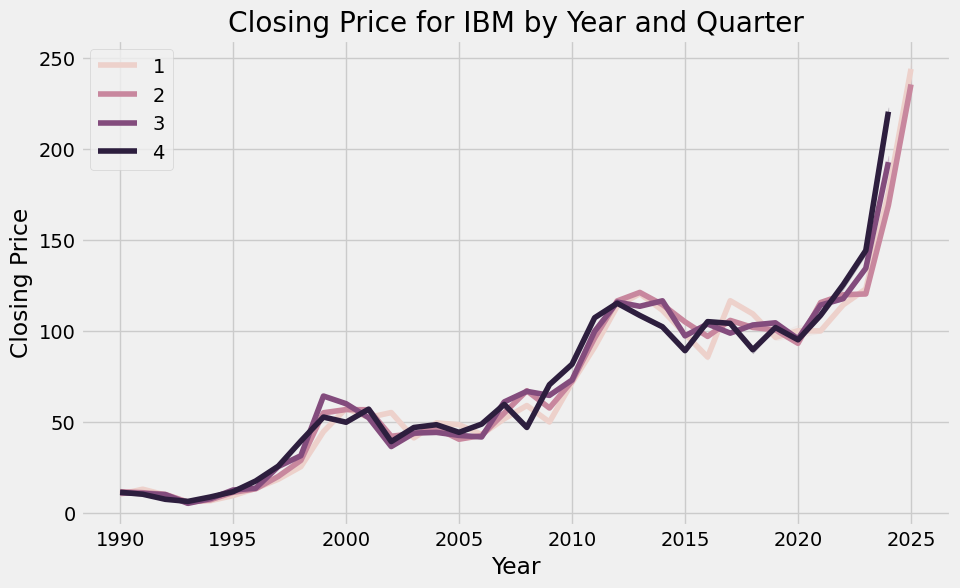

In [2]:

"""Copying 'df' to show the index for each time period"""

df1 = df.copy()

def create_values(df1):
    df1 = df1.copy()
    df1['year'] = df1.index.year
    df1['month'] = df1.index.month
    df1['dayofyear'] = df1.index.dayofyear
    df1['day'] = df1.index.day
    df1['quarter'] = df1.index.quarter

    return df1
    
df1 = create_values(df1)


plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='IBM',hue='quarter',data=df1)
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title("Closing Price for IBM by Year and Quarter")
plt.legend()
plt.show()

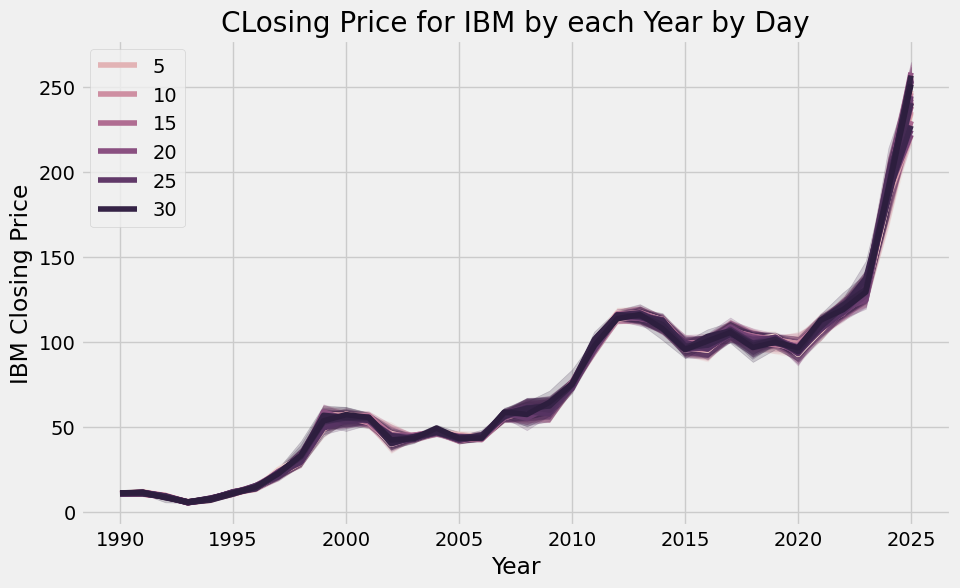

In [3]:
plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='IBM',hue='day',data=df1)
plt.title("CLosing Price for IBM by each Year by Day")
plt.xlabel("Year")
plt.ylabel("IBM Closing Price")
plt.legend()
plt.show()

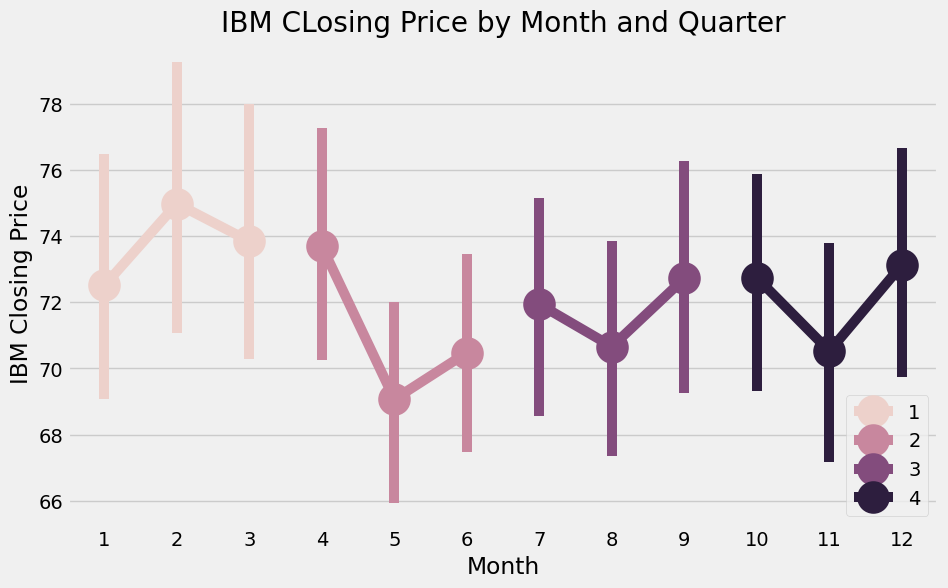

In [4]:
plt.figure(figsize=(10,6))
sns.pointplot(x='month',y='IBM',hue='quarter',data=df1)
plt.xlabel("Month")
plt.ylabel("IBM Closing Price")
plt.title("IBM CLosing Price by Month and Quarter")
plt.legend()
plt.show()

C:\Users\katsa\AppData\Local\Temp\ipykernel_23080\3564749272.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decomp.plot().show()


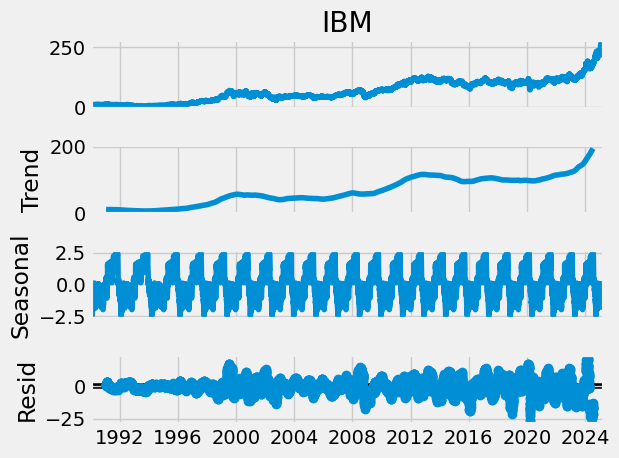

In [5]:
"""Seasonal Decomposition"""

decomp = seasonal_decompose(df['IBM'],model="additive",period=365)
decomp.plot().show()


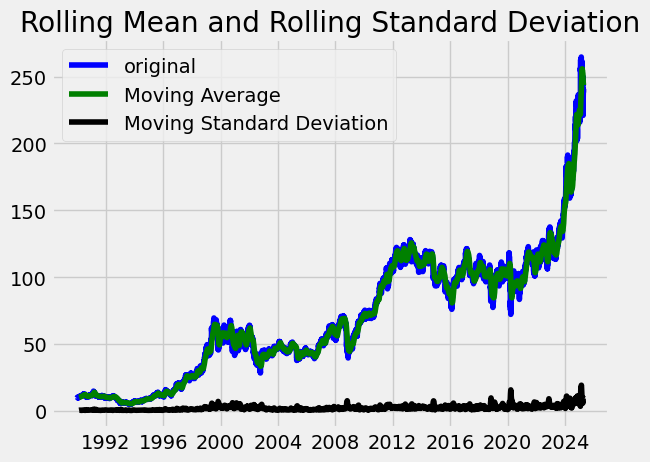

Results from Dickey Fueller

Test Statistic                    1.687227
p-value                           0.998097
'#Lags Used                      32.000000
Number of Observations Used    8146.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


In [6]:
def test_stationary(timeseries):
    
    movingaverage = timeseries.rolling(window=30).mean()
    movingstd = timeseries.rolling(window=30).std()
    plt.plot(timeseries,color="blue",label="original")
    plt.plot(movingaverage,color="green",label="Moving Average")
    plt.plot(movingstd,color="black",label="Moving Standard Deviation")
    plt.title("TimeSeries For IBM Closing Prices")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Rolling Standard Deviation")
    plt.show(block=False)
    
    print('Results from Dickey Fueller\n')
    df_test = adfuller(timeseries['IBM'],autolag="AIC")
    dfoutput = pd.Series(df_test[0:4],index=['Test Statistic','p-value',"'#Lags Used","Number of Observations Used"])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationary(df)

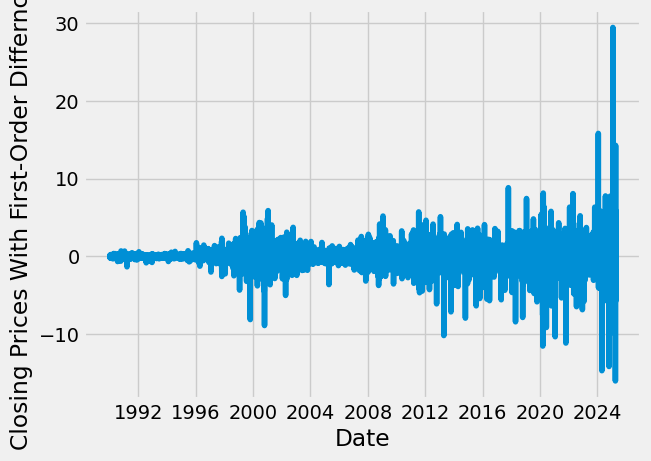

In [7]:

""" Need the p-value to be lower to be stationary First-order Differncing"""
df_diff = df.diff(periods=1)

plt.plot(figsize=(10,6))
plt.plot(df_diff)
plt.xlabel("Date")
plt.ylabel('Closing Prices With First-Order Differncing')
plt.show()

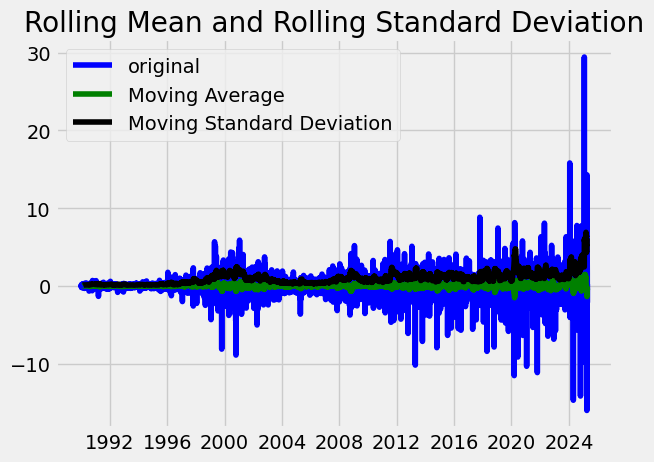

Results from Dickey Fueller

Test Statistic                  -19.764739
p-value                           0.000000
'#Lags Used                      26.000000
Number of Observations Used    8151.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


In [8]:
""" Stationary check for data with first-order differencing"""

df_diff.dropna(inplace=True)

test_stationary(df_diff)

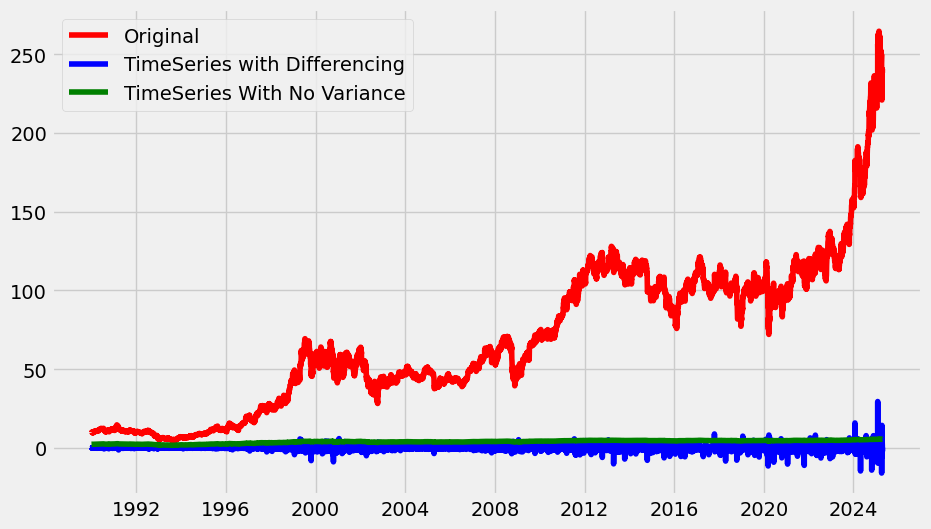

In [9]:
""" Just checking values with no variance to be safe"""


df_log=  np.log(df)



plt.figure(figsize=(10,6))
plt.plot(df,color="red",label="Original")
plt.plot(df_diff,color="blue",label="TimeSeries with Differencing")
plt.plot(df_log,color="green",label="TimeSeries With No Variance")
plt.legend()
plt.show()

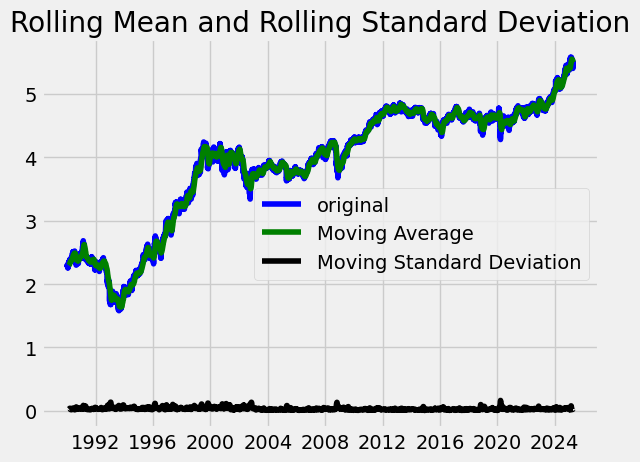

Results from Dickey Fueller

Test Statistic                   -1.084857
p-value                           0.721073
'#Lags Used                      22.000000
Number of Observations Used    8156.000000
Critical Value (1%)              -3.431152
Critical Value (5%)              -2.861894
Critical Value (10%)             -2.566959
dtype: float64


In [10]:
"""adf test for stationary with log values"""
df_log.dropna(inplace=True)
test_stationary(df_log)

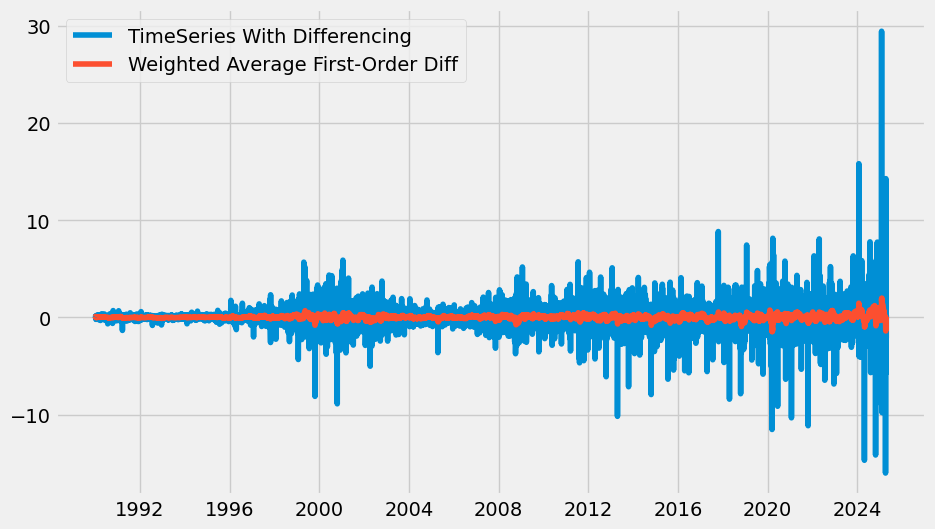

In [11]:

""" df differencing weighted average"""

df_diff_weighted_avg = df_diff.ewm(halflife=12).mean()
plt.figure(figsize=(10,6))
plt.plot(df_diff,label="TimeSeries With Differencing")
plt.plot(df_diff_weighted_avg,label="Weighted Average First-Order Diff")
plt.legend()
plt.show()

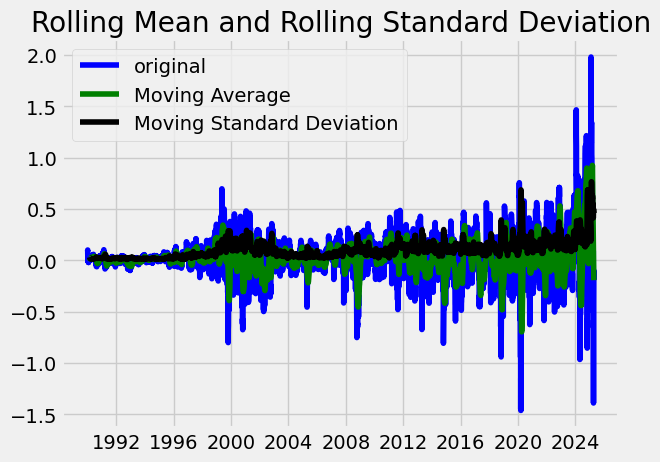

Results from Dickey Fueller

Test Statistic                -1.221619e+01
p-value                        1.134206e-22
'#Lags Used                    2.700000e+01
Number of Observations Used    8.150000e+03
Critical Value (1%)           -3.431153e+00
Critical Value (5%)           -2.861895e+00
Critical Value (10%)          -2.566959e+00
dtype: float64


In [12]:
df_diff_weighted_avg.dropna(inplace=True)
test_stationary(df_diff_weighted_avg)

C:\Users\katsa\AppData\Local\Temp\ipykernel_23080\499691467.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decomp.plot().show()


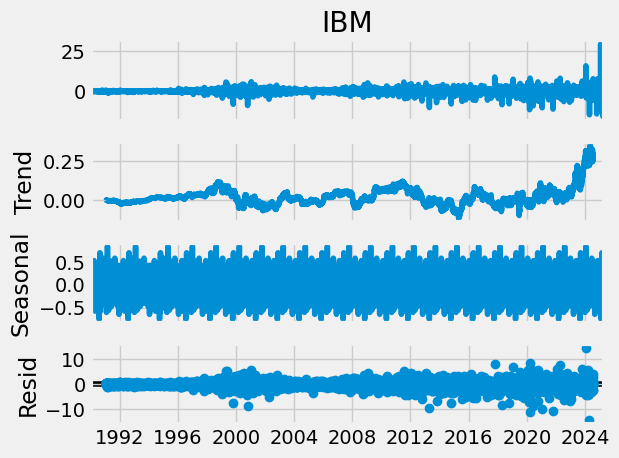

In [13]:

""" moving seasonal decomp with differncing"""

decomp = seasonal_decompose(df_diff['IBM'],model="additive",period=365)
decomp.plot().show()

In [14]:

""" Forecast Using XGBboost and other regular ML models first"""

df = create_values(df)
df.head(10)


X = df.drop('IBM',axis=1)
y= df['IBM']



X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:

""" A user-Defined function for metrics"""

def evaluate(y_test,pred,model_name,r2,mse,cv_scores):


    result = {
        "Model": model_name,
        "R2": r2,
        "MSE": mse,
        "Cross-val Scores":cv_scores.mean()
    }

    return result


model_dict = []
models = {
    "LinearRegression":LinearRegression(),
    "xgboost":XGBRegressor(),
    "gradientboostingregressor":GradientBoostingRegressor()
}


for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="neg_mean_squared_error")
    model_results = evaluate(y_test, pred, model_name,r2,mse,cv_scores)
    model_dict.append(model_results)



df_results = pd.DataFrame(model_dict)
print(df_results.head())

                       Model        R2         MSE  Cross-val Scores
0           LinearRegression  0.824070  377.570701       -391.683157
1                    xgboost  0.998827    2.517758         -3.028677
2  gradientboostingregressor  0.986335   29.326640        -27.336736


In [16]:

xgb = XGBRegressor().fit(X_train_scaled,y_train)
xgb_predictions = xgb.predict(X_test_scaled)
print(f'Predictions using the Best Model: {xgb_predictions}')


Predictions using the Best Model: [221.89433   47.577747 100.90494  ...  99.95799   36.627926  46.79978 ]


In [17]:
pred_vs_actual = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': xgb_predictions
}, index=y_test.index)



pred_vs_actual.sort_index(inplace=True)
print('Predicted Vs Actual Prices\n')
print(pred_vs_actual)

Predicted Vs Actual Prices

                Actual   Predicted
Date                              
1990-01-26    9.605205    9.495625
1990-02-01    9.691962   10.155567
1990-02-07   10.352226   10.214783
1990-02-12   10.151455   10.514687
1990-02-21   10.527902   10.609031
...                ...         ...
2025-03-14  248.350006  251.962036
2025-03-31  248.660004  245.331741
2025-04-03  243.490005  229.365845
2025-04-07  225.779999  233.596985
2025-04-08  221.029999  233.340347

[1636 rows x 2 columns]


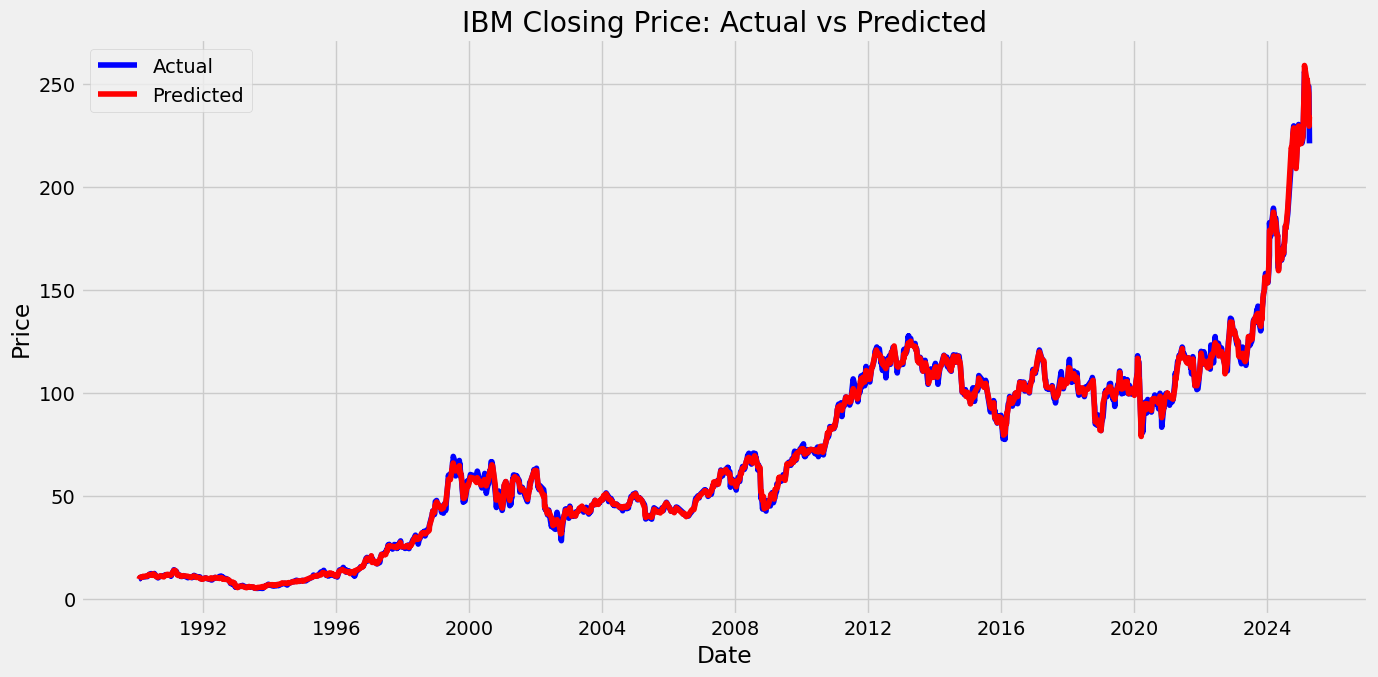

In [18]:

plt.figure(figsize=(14,7))
plt.plot(pred_vs_actual.index, pred_vs_actual['Actual'], label='Actual', color='blue')
plt.plot(pred_vs_actual.index, pred_vs_actual['Predicted'], label='Predicted', color='red')
plt.title('IBM Closing Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
